<a href="https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/Detrending_HartRAO_OH_monitoring_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Backend scripts and data file from GitHub

In [2]:
!git clone 'https://github.com/rubyvanrooyen/HartRAO_OH-IR_stars.git'
!ln -s HartRAO_OH-IR_stars/hart_io.py
!ln -s HartRAO_OH-IR_stars/detrend.py

fatal: destination path 'HartRAO_OH-IR_stars' already exists and is not an empty directory.
ln: failed to create symbolic link './hart_io.py': File exists


# Data input
Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

Input data file with selected blue and red channel data only as generated in `Visualising_HartRAO_OH_monitoring_data` notebook

In [40]:
# Importing files method from colab for accessing Local file system
from google.colab import files
uploaded = files.upload()

import io
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    bytes_io = io.BytesIO(uploaded[fn])
    byte_str = bytes_io.read()
    f = io.StringIO(byte_str.decode('UTF-8'))

Saving IKTau_ts_blue4_red12.tscat to IKTau_ts_blue4_red12.tscat
User uploaded file "IKTau_ts_blue4_red12.tscat" with length 5453 bytes


In [41]:
#@title User input and parameters

#@markdown Name of source as in data file
source = "IKTau" #@param ["Type here", "IKTau", "VMic"]  {allow-input: true}
#@markdown Julian date format for timestamp conversion
tsformat = 'mjd' #@param ["mjd", "jd"]
#@markdown Observation epoch for "jd" to "mjd" time conversion
epoch = 0. #@param {type:"number"}

print(f"Reading '{source}' OH monitoring file")
print(f"Assuming epoch {epoch} and "
      f"'{tsformat}' format for time interpretation")

Reading 'IKTau' OH monitoring file
Assuming epoch 0.0 and 'mjd' format for time interpretation


In [42]:
# read input data assuming HartRAO format
import hart_io as io
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(file_obj=f,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [43]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')
[nts, nch] = spectra.shape

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 46.886

Spectral data size (#ts, #ch) = (170, 2)


# Data detrending
Removing long term trends with low order polynomial fittings

In [44]:
import matplotlib.pylab as plt
import matplotlib.mlab as mlab

import numpy as np
import os

from matplotlib import gridspec

In [45]:
import detrend

def find_polyorder(xdata, ydata, npoly=3, verbose=False):
    
    poly_range = range(1,npoly+1)
    
    means = []
    plus_sigma = []
    neg_sigma = []
    report = 'npoly \t mean \t\t std<0 \t\t std>0 \n'
    for poly_order in poly_range:
        ffit = detrend.polyfit(xdata, ydata, poly_order)
        detrended_flux = ydata - ffit(xdata)
    
        means.append(np.mean(detrended_flux))
        plus_sigma.append(np.std(detrended_flux[detrended_flux>0]))
        neg_sigma.append(np.std(detrended_flux[detrended_flux<0]))
        report += '{} \t {:.3e} \t {:.4f} \t {:.4f} \n'.format(poly_order,
                                                               means[-1],
                                                               neg_sigma[-1],
                                                               plus_sigma[-1])

    if verbose: print(report)
    sigma_diff = np.abs(np.array(plus_sigma)-np.array(neg_sigma))
    return poly_range[np.argmin(sigma_diff)]

npoly 	 mean 		 std<0 		 std>0 
1 	 -2.560e-15 	 1.0250 	 1.0619 
2 	 2.466e-15 	 1.0164 	 1.0931 

npoly 	 mean 		 std<0 		 std>0 
1 	 1.045e-17 	 0.4437 	 0.5020 
2 	 2.735e-15 	 0.4239 	 0.5016 



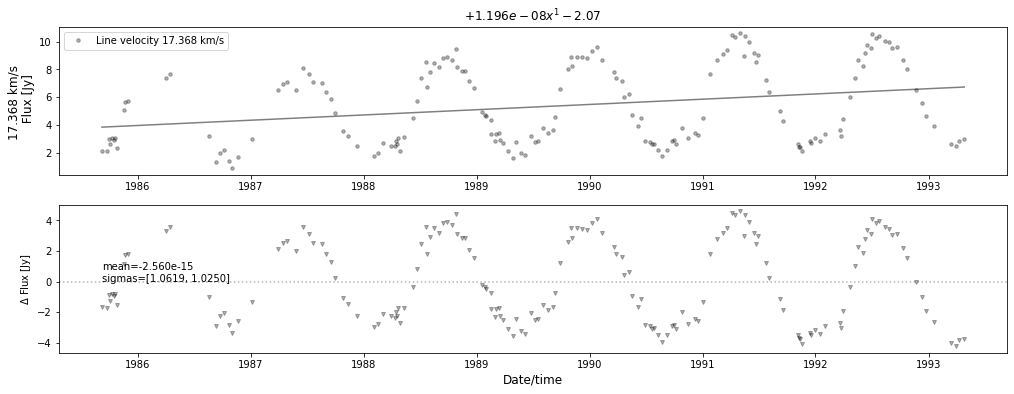

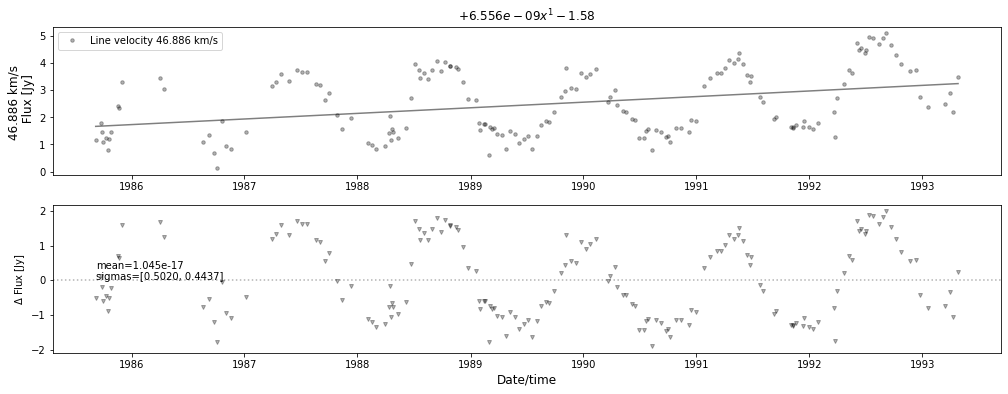

In [46]:
def sign(x):
    if x < 0: return '-'
    else: return '+'

velocity = {0: 'blue', 1: 'red'}

detrended_spectra = []
for channel in range(nch):
    flux = spectra[:, channel]
    poly_order = find_polyorder(ts_jd.unix,
                                flux,
                                npoly=2, verbose=True)
    
    ffit = detrend.polyfit(ts_jd.unix, flux, poly_order)
    detrended_flux = flux - ffit(ts_jd.unix)
    
    fig= plt.subplots(figsize=(17,6),
                      facecolor='white')
    gs = gridspec.GridSpec(2, 1)
    ax0 = plt.subplot(gs[0])
    ax0.plot(ts_jd.datetime, flux,
             color='k', marker='.', linestyle='none', markersize=7, alpha=0.3,
             label=r'Line velocity {} km/s'.format(chan_vel[channel]))
    ax0.plot(ts_jd.datetime, ffit(ts_jd.unix),
             color='k', marker=',', linestyle='-', markersize=0, alpha=0.5)
    ax0.legend(loc=0)
    ax0.set_ylabel('{} km/s \n Flux [Jy]'.format(chan_vel[channel]), fontsize=12)
    title = ''
    coeffs = ffit.coeffs[:-1]
    for cnt, coeff in enumerate(coeffs):
        title += ' {} {:.3e} x^{}'.format(sign(coeff), abs(coeff), len(coeffs)-cnt)
    title+=' {} {:.2f}'.format(sign(ffit.coeffs[-1]), abs(ffit.coeffs[-1]))
    ax0.set_title(r'$%s$' % title)
        
    ax1 = plt.subplot(gs[1])
    ax1.plot(ts_jd.datetime, detrended_flux,
             color='k', marker='v', linestyle='none', markersize=4, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle=':', alpha=0.3)
    ax1.set_xlabel('Time [Yrs]')
    ax1.set_ylabel(r'$\Delta$ Flux [Jy]')
    ax1.set_xlabel('Date/time', fontsize=12)
    mean = np.mean(detrended_flux)
    plus_sigma = np.std(detrended_flux[detrended_flux>0])
    neg_sigma = np.std(detrended_flux[detrended_flux<0])
    anno_text = 'mean={:.3e}\nsigmas=[{:.4f}, {:.4f}]'.format(mean, plus_sigma, neg_sigma)
    style = dict(size=10, color='black')
    ax1.text(ts_jd.datetime[0], 0, anno_text, **style)
    
    if len(detrended_spectra) < 1:
        detrended_spectra = detrended_flux
    else:
        detrended_spectra = np.vstack([detrended_spectra, detrended_flux])
        
plt.show()

Cleaned data (dots) show a long term trend over time, which is easily removed by subtracting a low order polynomial

In [47]:
def timeseries(xdata, ydata,
               label=None, color='k', marker='.', linestyle=':', alpha=1.,
               fig=None, ax=None,
               ):
    if ax is None:
        fig = plt.subplots(figsize=(17, 5),
                           facecolor='white')
        ax = plt.subplot(111)
    ax.plot(xdata,
            ydata,
            color=color,
            marker=marker,
            ls=linestyle,
            alpha=alpha,
            label=label)

    if label is not None:
        ax.legend(loc=0)

    return fig, ax

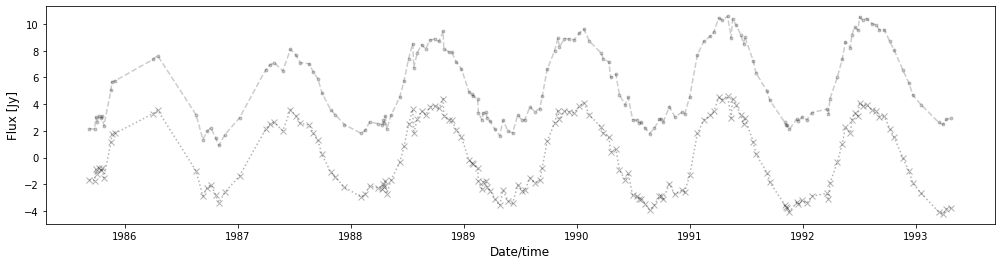

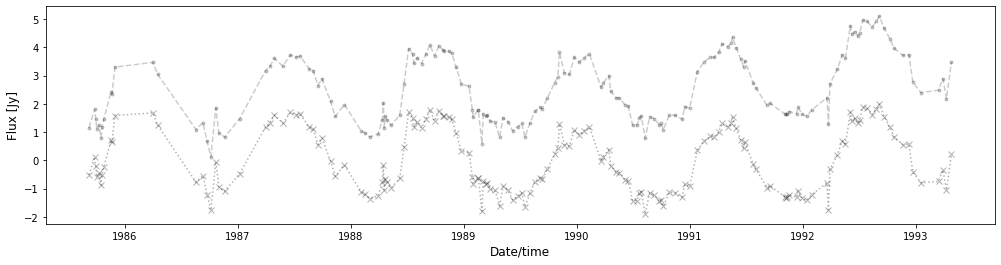

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 0],
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[0, :],
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 1],
                     color='k', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[1, :],
                     color='k', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)
ax.set_ylabel('Flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)

plt.show()

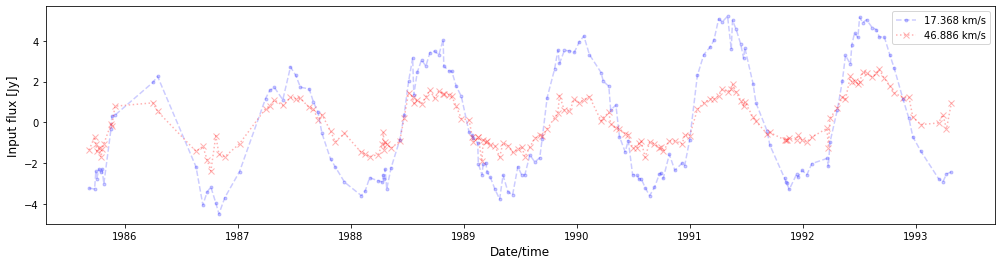

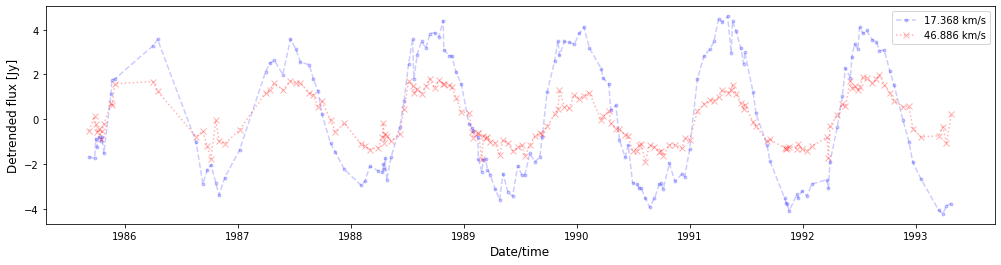

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, spectra[:, 0]-np.mean(spectra[:, 0]),
                     color='b', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, spectra[:, 1]-np.mean(spectra[:, 1]),
                     color='r', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)

labels = ['{} km/s'.format(chan_vel[0]), '{} km/s'.format(chan_vel[1])] 
ax.set_ylabel('Input flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)
ax.legend(labels, loc=0)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
fig, ax = timeseries(ts_jd.datetime, detrended_spectra[0, :],
                     color='b', marker='.', linestyle='--', alpha=0.2,
                     fig=fig, ax=ax)

fig, ax = timeseries(ts_jd.datetime, detrended_spectra[1, :],
                     color='r', marker='x', linestyle=':', alpha=0.3,
                     fig=fig, ax=ax)

labels = ['{} km/s'.format(chan_vel[0]), '{} km/s'.format(chan_vel[1])] 
ax.set_ylabel('Detrended flux [Jy]', fontsize=12)
ax.set_xlabel('Date/time', fontsize=12)
ax.legend(labels, loc=0)

plt.show()

In [50]:
filename = list(uploaded.keys())[0]
outfile = os.path.basename(filename)
[name, ext] = os.path.splitext(outfile)
outfile = '{}_detrended{}'.format(name, ext)

[comment, head_line] = header.strip().split('\n')
comment ='{}\n'.format(comment.strip())
comment += '{}, {:.3f}, {:.3f}\n'.format(head_line.split(',')[0], chan_vel[0], chan_vel[1])

io.output(outfile, comment, timestamps, detrended_spectra.T)

print(f'Extracted channel data saved to file {outfile}')
print('IMPORTANT: User must download this file for futher processing and before closing notebook if executed in COLAB.')

Extracted channel data saved to file IKTau_ts_blue4_red12_detrended.tscat
IMPORTANT: User must download this file for futher processing and before closing notebook if executed in COLAB.
